# Programa para plotar analises sinoticas com dados do ERA 5

In [1]:
import xarray as xr
import numpy as np
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import scipy.ndimage as ndimage

In [2]:
file_levels = 'Data_levels.nc'
file_sfc = 'Data_superficie.nc'

In [3]:
ds_plevs = xr.open_dataset(file_levels)
ds_sfc = xr.open_dataset(file_sfc)


In [4]:
def plot_main_map(shapefolder, grid_spc=10, extent=[-80, -30, -55, 10]):
    proj = ccrs.PlateCarree(central_longitude=-57.5)
    trans = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(6, 4), facecolor='w', subplot_kw=dict(projection=proj))
    ax.set_extent(extent, crs=trans)
    shapename = 'Brasil.shp'
    shapename_america = 'America_do_Sul.shp'
    ax.add_geometries(shpreader.Reader(shapename).geometries(), trans,
        linewidth=1.0, facecolor='none', edgecolor='darkslategray',zorder=3)
    ax.add_geometries(shpreader.Reader(shapename_america).geometries(), trans,
        linewidth=1.0, facecolor='none', edgecolor='darkslategray',zorder=3)
    gl = ax.gridlines(crs=trans, xlocs=np.arange(-180, 181, grid_spc),
                    ylocs=np.arange(-80, 90, grid_spc), draw_labels=True)
    gl.right_labels = gl.top_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax, trans

In [5]:
def plot_sfc(data,data_sfc,**kwargs):
    fig, ax, trans = plot_main_map(shapefolder=('...'))
    clevs_q = np.arange(10,20,2)
    q_cont = ax.contourf(
        data['longitude'], data['latitude'],(data['q'].sel(level=925))*1000, 
        clevs_q, cmap=plt.get_cmap('GnBu'), zorder=2, extend='both', transform=trans)
    fig.colorbar(q_cont, spacing='uniform',
                label='Umidade específica 925 hPa (' + r'$g kg^{-1}$' + ')', shrink=0.945,
                 pad=0.025)
    u = (data['u'].sel(level=925))*1.94
    v = (data['v'].sel(level=925))*1.94
    vento = ax.barbs(np.asarray(data['longitude']),np.asarray(data['latitude']), np.asarray(u),np.asarray(v), 
             regrid_shape=15, zorder=4, transform=trans, length=5, linewidth=0.6,
             flip_barb=True, barbcolor ='r')
    mslp_cont = ax.contour(
        data_sfc['longitude'], data_sfc['latitude'], ndimage.gaussian_filter(data_sfc['msl'], sigma=3, order=0)/100, 
        levels=np.arange(950, 1050, 2), colors='k', linewidths=0.8, zorder=3, transform=trans)
    plt.clabel(mslp_cont, np.arange(950, 1050, 4), inline=True, fmt='%1i',
               fontsize=8, use_clabeltext=True)
    plt.title(kwargs.get('title_plot'), weight='bold', stretch='condensed',
              size='medium', position=(0.55, 1))
    plt.savefig((kwargs.get('title_figure')), dpi=300, bbox_inches='tight')
    plt.close()

In [6]:
def plot_low(data,**kwargs):
    """
    Funcao para plotar umidade especifica , vento e geopotencial em 850 hPa
    """
    fig, ax, trans = plot_main_map(shapefolder=('...'))
    color_map = plt.get_cmap('cubehelix')
    reversed_color_map = color_map.reversed()
    clevs_q = np.arange(10,20,2)
    q_cont = ax.contourf(
        data['longitude'], data['latitude'],(data['q'].sel(level=850))*1000,
        clevs_q, cmap=reversed_color_map, zorder=2, extend='both', transform=trans) 
    fig.colorbar(q_cont, spacing='uniform',
                label='Umidade específica (' + r'$g kg^{-1}$' + ')', shrink=0.945,
                 pad=0.025)
    u = (data['u'].sel(level=850))*1.94
    v = (data['v'].sel(level=850))*1.94
    vento = ax.barbs(np.asarray(data['longitude']),np.asarray(data['latitude']), np.asarray(u),np.asarray(v),
                  regrid_shape=15,zorder=4, transform=trans, length=5, linewidth=0.6,
             flip_barb=True, barbcolor ='r')
    geo = ndimage.gaussian_filter(data['z'].sel(level=850)/9.81/10, sigma=3, order=0)
    geo_cont = ax.contour(
        data['longitude'], data['latitude'], geo,
       levels=np.arange(114, 196, 2),
        colors='k', linewidths=0.8, zorder=3, transform=trans)
    plt.clabel(geo_cont, np.arange(114, 196, 2),inline=True, fmt='%1i',
               fontsize=8, use_clabeltext=True)
    plt.title(kwargs.get('title_plot'), weight='bold', stretch='condensed',
              size='medium', position=(0.55, 1))
    plt.savefig((kwargs.get('title_figure')), dpi=300, bbox_inches='tight')
    plt.close()

In [11]:
def plot_mid(data,**kwargs):
    """
    Funcao para plotar vel vertical, vento, alt geopotencial e temperatura em 500 hPa
    """
    fig, ax, trans = plot_main_map(shapefolder=('...'))
    clevs_w = np.arange(-0.5,0.51,0.1)
    w_cont = ax.contourf(
        data['longitude'], data['latitude'],data['w'].sel(level=500),clevs_w, 
         cmap=plt.get_cmap('RdBu'),  zorder=2,extend='both', transform=trans) 
    fig.colorbar(w_cont, spacing='uniform',
                label='Velocidade vertical (' + r'$Pa s^{-1}$' + ')', shrink=0.945,
                 pad=0.025)
    u = (data['u'].sel(level=500))*1.94
    v = (data['v'].sel(level=500))*1.94
    vento = ax.barbs(np.asarray(data['longitude']),np.asarray(data['latitude']), np.asarray(u),np.asarray(v), 
                 regrid_shape=15, zorder=4, transform=trans, length=5, linewidth=0.6,
             flip_barb=True, barbcolor ='r')
    geo = ndimage.gaussian_filter(data['z'].sel(level=500)/9.81/10, sigma=3, order=0)
    z_cont = ax.contour(
        data['longitude'], data['latitude'], geo,levels=np.arange(570, 600, 2),
        colors='k', linewidths=0.8, zorder=3, transform=trans)
    plt.clabel(z_cont, np.arange(570, 600, 2),inline=True, fmt='%1i',
               fontsize=8, use_clabeltext=True)
    temp_cont = ax.contour(
        data['longitude'], data['latitude'], data['t'].sel(level=500),levels=np.arange(-20, 5, 5),
        colors='green',linestyles='dashed', linewidths=0.8, zorder=3, transform=trans)
    plt.clabel(temp_cont, levels=[-20,-10,0],inline=True, fmt='%1i',
               fontsize=8, use_clabeltext=True)
    plt.title(kwargs.get('title_plot'), weight='bold', stretch='condensed',
              size='medium', position=(0.55, 1))
    plt.savefig((kwargs.get('title_figure')), dpi=300, bbox_inches='tight')
    plt.close()

In [7]:
def plot_upper_div(data,**kwargs):
    """
    Programa para plotar divergencia e linhas de corrente em 200
    """
    fig, ax, trans = plot_main_map(shapefolder=('...'))
    clevs_div = np.arange(0,4.2,0.2)
    ticks=[0,2.0,4.0]
    div_cont = ax.contourf(
        data['longitude'], data['latitude'],(data['d'].sel(level=200))*100000,
        clevs_div, cmap=plt.get_cmap('Oranges'), zorder=2,  extend='both', transform=trans) 
    fig.colorbar(div_cont, spacing='uniform',ticks=ticks, 
                label='Divergência (' + r'$10^{-5} s^{-1}$' + ')', shrink=0.945,
                 pad=0.025)
    u = data['u'].sel(level=200)
    v = data['v'].sel(level=200)
    vento = ax.streamplot(np.asarray(data['longitude']),np.asarray(data['latitude']), np.asarray(u),np.asarray(v),
                           density=2,linewidth=0.5, arrowsize=0.8,
                       color='k', transform=trans)
    plt.title(kwargs.get('title_plot'), weight='bold', stretch='condensed',
              size='medium', position=(0.55, 1))
    plt.savefig((kwargs.get('title_figure')), dpi=300, bbox_inches='tight')
    plt.close()

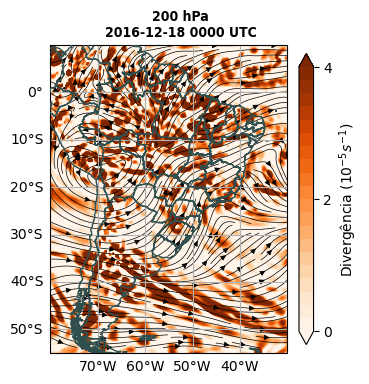

In [8]:
for t in range(0,24):
    subds_plevs = ds_plevs.isel(time=t) 
    subds_sfc = ds_sfc.isel(time=t)
    date_full = subds_plevs['time'].values
    date = np.datetime_as_string(date_full, unit='s').partition('T')[0]
    time = np.datetime_as_string(date_full, unit='s').partition('T')[2]
    time = time.replace(":", "")[:-2]
    plot_sfc(subds_plevs, subds_sfc, title_plot=, title_figure='_sfc_' + date.replace('-', '') + time) 
    plot_low(subds_plevs, title_plot='850 hPa\n' + date + ' ' + time + ' UTC',title_figure='_850_' + date.replace('-', '') + time)
    plot_mid(subds_plevs, title_plot='500 hPa\n' + date + ' ' + time + ' UTC',title_figure='_500_' + date.replace('-', '') + time)
    plot_upper_div(subds_plevs, title_plot='200 hPa\n' + date + ' ' + time + ' UTC',title_figure='_200_' + date.replace('-', '') + time)